### Imports

In [ ]:
import torch

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood 
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.kernels.matern_kernel import MaternKernel

from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

import numpy as np
import tqdm

%load_ext autoreload
%autoreload 2

: 

In [2]:
# RAHBO imports

# import rahbo
from problems.k1 import K1
# from rahbo.optimization.bo_step import bo_step, bo_step_risk_averse


### Global variables

$\text{Variable that define the experimental setup (description in the comments)}$

In [3]:
GLOBAL_VARS = {
    'gamma': 1, # risk-tolerance constant for rahbo (corresponds to \alpha in the RAHBO paper)
    'sigma': 5, # noise variance in the area with maximum noise
    'seed': 1,  # random seed for initial evaluations generation
    'n_budget': 10, # number of BO iterations
    'n_budget_var': 5, # number of BO iterations to be used for variance learning (relevant only for RAHBO-US)
    'repeat_eval': 3, # number of evaluations at the same point
    'beta': 2, # hyperparameter for UCB acquisition function
    'n_bo_restarts': 6, # number of BO restarts (used for experiments plots in the paper)
    'n_initial': 12 # number of initial points for BO (used to choose GP)
}

### Helpers functions

#### Model



### Risk-averse BO aka RAHBO

In [4]:
K1 = K1Benchmark(GLOBAL_VARS)
    
x = K1.get_random_initial_points(num_points=GLOBAL_VARS['n_initial'], seed=GLOBAL_VARS['seed'])
y = K1.evaluate(x)
yvar = y.var(dim=-1)
ymean = y.mean(dim=-1)
yvar_true = K1.get_noise_var(x)

#### Model

We model both the K1 function and the noise variance

In [5]:
# Variance model

# Here we use a standard GP with homoscedastic noise (SingleTaskGP) where default Matern kernel is used
# You can choose GP with the kernels that fits best to your data

gp_model_varproxi = SingleTaskGP(x, yvar).to(x)
mll_varproxi = ExactMarginalLogLikelihood(gp_model_varproxi.likelihood, gp_model_varproxi)
fit_gpytorch_model(mll_varproxi)

c:\Users\queim\micromambaenv\envs\bo_env\lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
c:\Users\queim\micromambaenv\envs\bo_env\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\queim\micromambaenv\envs\bo_env\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([2.1762e+01, 5.8390e-04]), std = tensor([7.4035e+01, 8.4411e-04])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [6]:
# Function model

gp_model = FixedNoiseGP(x, ymean, yvar).to(x)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

gp_model.eval()
gp_model.likelihood.eval()

n_grid = 100

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    
    #create np meshgrid and flatten it for the GP
    x2 = np.linspace(0, 1, n_grid)
    x1 = np.linspace(0.5, 3.5, n_grid)
    x1_mesh, x2_mesh = np.meshgrid(x1, x2)
    mesh = torch.from_numpy(np.vstack((x1_mesh.flatten(), x2_mesh.flatten())).T).float64()
    
    observed_pred = gp_model(mesh)

c:\Users\queim\micromambaenv\envs\bo_env\lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
c:\Users\queim\micromambaenv\envs\bo_env\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\queim\micromambaenv\envs\bo_env\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-13.4222,   0.2862]), std = tensor([7.7443, 0.3505])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
c:\Users\qu

AttributeError: 'Tensor' object has no attribute 'float64'

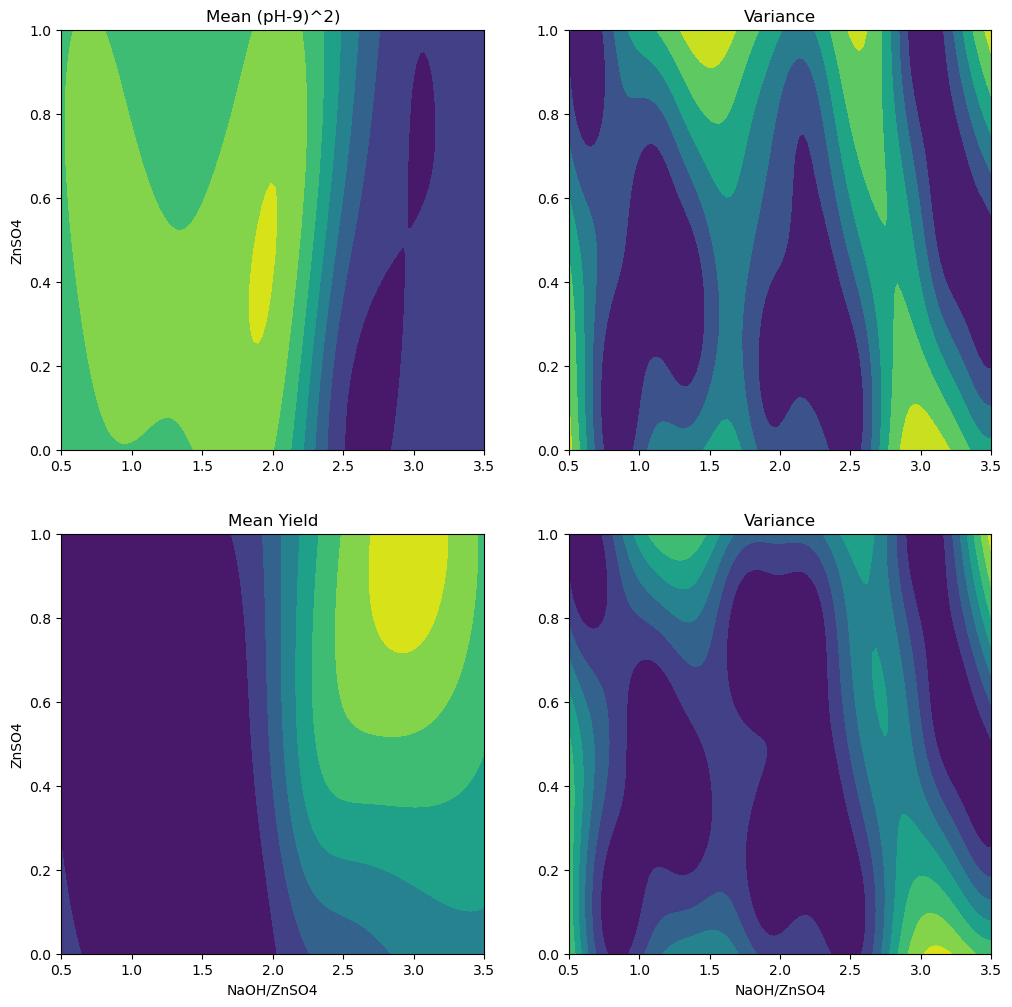

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#reshape meshgrid for plotting
x1_mesh = x1_mesh.reshape((n_grid,n_grid))  
x2_mesh = x2_mesh.reshape((n_grid,n_grid))
mean = observed_pred.mean.T.reshape((n_grid,n_grid,2))
var = observed_pred.variance.T.reshape((n_grid,n_grid,2))
 
 # 2x2 subplots mean and variance
yaxis_title="ZnSO4"
xaxis_title="NaOH/ZnSO4"
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0,0].set_title('Mean (pH-9)^2)')
axes[0,1].set_title('Variance')
axes[1,0].set_title('Mean Yield')
axes[1,1].set_title('Variance')
axes[0,0].set_ylabel(yaxis_title)
axes[1,0].set_ylabel(yaxis_title)
axes[1,0].set_xlabel(xaxis_title)
axes[1,1].set_xlabel(xaxis_title)
# colorbar axes

axes[0,0].contourf(x1_mesh, x2_mesh, mean[:,:,0].numpy())
axes[0,1].contourf(x1_mesh, x2_mesh, var[:,:,0].numpy())
axes[1,0].contourf(x1_mesh, x2_mesh, mean[:,:,1].numpy())
axes[1,1].contourf(x1_mesh, x2_mesh, var[:,:,1].numpy())



In [ ]:
import plotly.graph_objects as go


fig = go.Figure(
    data=[
        go.Surface(
            x=x1_mesh,
            y=x2_mesh,
            z=mean[:, :, 0].numpy(),
            opacity=0.8,
            surfacecolor=var[:, :, 0].numpy(),
            #add color
            colorscale='Viridis'
              
             
        ) 
    ] 
)

fig.add_trace(
    go.Surface(
        x=x1_mesh,
        y=x2_mesh,
        z=mean[:, :, 1].numpy(),
        opacity=0.8,
        surfacecolor=var[:, :, 1].numpy(),
    )
)

# add evaluation points
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=ymean[:, 0],
        mode="markers",
        marker=dict(
            size=3, color="red", symbol="x", line=dict(color="red", width=6)
        ),
    )
)
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=ymean[:, 1],
        mode="markers",
        marker=dict(
            size=3, color="red", symbol="x", line=dict(color="purple", width=6)
        ),
    )
)

# Update layout
fig.update_layout(
    title="Surface Plot",
    title_font_size=20,
    title_x=0.5,  # Center title
    font=dict(family="Arial, sans-serif", size=12, color="black"),  # Professional font
    scene=dict(
        xaxis_title="X Axis Title",  # Replace with your title
        yaxis_title="Y Axis Title",  # Replace with your title
        zaxis_title="Z Axis Title",  # Replace with your title
        xaxis=dict(showgrid=True, gridwidth=1, gridcolor="lightgrey"),
        yaxis=dict(showgrid=True, gridwidth=1, gridcolor="lightgrey"),
        zaxis=dict(showgrid=True, gridwidth=1, gridcolor="lightgrey"),
    ),
    margin=dict(l=65, r=50, b=65, t=90),
)
# axis labels
fig.update_layout(
    scene=dict(yaxis_title="ZnSO4", xaxis_title="NaOH/ZnSO4", zaxis_title="(pH - 9)^2"),
    title="pH",
    autosize=False,
    width=800,
    height=800,
)

fig.show()

# 3d scatter

#### Acquisition function

In [ ]:
from rahbo.acquisition.acquisition import RiskAverseUpperConfidenceBound
rahbo = RiskAverseUpperConfidenceBound(gp_model, gp_model_varproxi, 
                                        beta=GLOBAL_VARS['beta'], beta_varproxi=GLOBAL_VARS['beta'],
                                        gamma=GLOBAL_VARS['gamma'])

# Domain over which the acq function is optimized
bounds = K1.get_domain()

candidate, acq_value = optimize_acqf(
    rahbo, bounds=bounds, q=1, num_restarts=GLOBAL_VARS['n_bo_restarts'], raw_samples=20,
)

candidate

TypeError: __init__() got an unexpected keyword argument 'objective'

#### Optimization loop

In [ ]:
K1 = K1Benchmark(GLOBAL_VARS)
objective = K1.evaluate
bounds = K1.get_domain()


inputs_all_rahbo = []
results_all_rahbo = []
animations_rahbo = []
last_plots = []

for restart in range(GLOBAL_VARS['n_bo_restarts']):

    axes = []
    fig = None
    
    results = {}
    
    x = K1.get_random_initial_points(num_points=GLOBAL_VARS['n_initial'], seed=GLOBAL_VARS['seed'] + restart)
    y = objective(x)
    yvar = y.var(dim=1, keepdim=True)
    ymean = y.mean(dim=1, keepdim=True)
    yvar_true = K1.get_noise_var(x)
    
    inputs = x
    scores = ymean
    scores_var = yvar
    state_dict = None


    best_observed = []
    best_observed.append(scores.max())

    
    total_iters = GLOBAL_VARS['n_budget']
    with tqdm.tqdm(total=total_iters) as bar:
        for iteration in range(1, total_iters + 1):

            n_samples = len(scores)

            GP = FixedNoiseGP
            acquisition = lambda gp, gp_var: RiskAverseUpperConfidenceBound(gp, gp_var,
                                                                            beta=GLOBAL_VARS['beta'], 
                                                                            beta_varproxi=GLOBAL_VARS['beta'],
                                                                            gamma=GLOBAL_VARS['gamma']
                                                                            )

            inputs, scores, gp, scores_var, gp_var = bo_step_risk_averse(inputs, scores, objective, bounds,
                                                                      GP=GP, acquisition=acquisition, q=1,
                                                                      state_dict=state_dict,
                                                                      train_Yvar=scores_var)
            
            state_dict = gp.state_dict()
            best_observed.append(scores.max())
            bar.update(len(scores) - n_samples)
            
            with torch.no_grad():
                fig, axes = plot_bo_step(inputs, scores, gp, acquisition(gp, gp_var), beta=GLOBAL_VARS['beta'],
                                         title='RAHBO', fig=fig, axes=axes, iteration=iteration) 
    animations_rahbo.append(animation.ArtistAnimation(fig, artists=axes, interval=10000/24))
    plt.close() 
    
    inputs_all_rahbo.append(inputs)
    results['inputs'] = inputs
    results['scores'] = scores
    results['scores_var'] = scores_var
    results['scores_best'] = best_observed
    results_all_rahbo.append(results)

#### Animation

In [ ]:
a = animations_rahbo[0]

for i in a.frame_seq:
    plt.show(i)

In [ ]:
animations_rahbo[0]

In [ ]:
# We visualizae the acuquision for all seeds
for a in animations_rahbo:
    display(HTML(a.to_html5_video()))

### Conclusion

In this notebook, we illustated the behavours differences between heteroscedastic GP-UCB and RAHBO. While GP-UCB might stuck in the area with high noise, that does not happen with RAHBO. Consequently